##CNNs & Transfer Learning

In this example we will work with convolutional networks applied for the classification of color images using the CIFAR10 dataset. Later we will explore the limitations of models built from scratch with the Imagenette dataset, and how we can take advantage of pre-trained models through transfer learning.

In [ ]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout, InputLayer
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

# dataset MNIST
from keras.datasets import cifar10

### CIFAR10

CIFAR10 is a simplified version of the CIFAR100 (Canadian Institute For Advanced Research) dataset, which consists of 60,000 32x32 pixel color images for 10 classes, with 6,000 images per class.

**1. Dataset exploration**

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
# dataset sizes
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


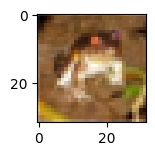

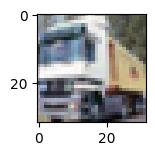

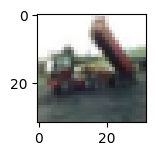

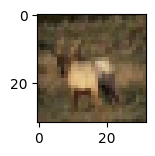

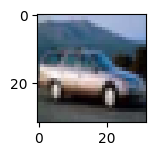

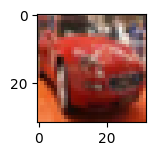

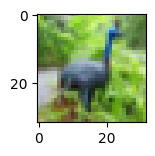

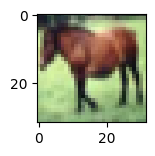

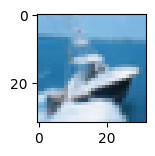

In [ ]:
# image display
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i])
  plt.show()

Tenemos un total de 10 clases de objetos.

In [ ]:
# clases únicas
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**2. Data preprocessing**

Como tenemos imágenes a color, ajustamos el tamaño de los tensores de entrada para que podamos tratarlos en el modelo.

In [ ]:
# convert the input tensors
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Each RGB color channel has values ​​between 0-255. In order to introduce them to the model, it is necessary to rescaling them to 0-1.

In [ ]:
# scaling
X_train = X_train / 255.0
X_test = X_test / 255.0

We use one-hot encoding to create a binary column for each class.

In [ ]:
# one-hot encoding
print('Before encoding: {}'.format(y_train.shape))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('After encoding: {}'.format(y_train.shape))

Forma antes del encoding: (50000, 1)
Forma después del encoding: (50000, 10)


In [ ]:
pd.DataFrame(y_train).head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**3. Construction of the neural network: Without Dropout**

We build a classification model using convolutional neural networks. Since we adjust the inputs to combine the channels into a single dimension, we can use the Conv2D layer (otherwise we would need to use Conv3D). We combine various layers of multiple filters to capture the color information of the images.

In [ ]:
# baseline model
def baseline_model(X):
  # declaramos un modelo secuencial
  model = Sequential()

  # capas convolucionales
  model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))
  model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  # capa de aplanamiento
  model.add(Flatten())

  # capas densamente conectadas
  model.add(Dense(500, activation='relu'))
  model.add(Dense(250, activation='relu'))

  # capa de salida (10 clases)
  model.add(Dense(10, activation='softmax'))

  # compilar modelo
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

  return model

In [ ]:
# instantiate model object
model = baseline_model(X_train)

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 50)        1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 75)        33825     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 75)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 125)       84500     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 125)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8000)              0

The first layer has 50 3x3 filters for 3 channels (RGB), with their respective 50 bias.

In total we have: ((3x3)x50)x3 + 50 = 1400 pesos.

In [ ]:
# model training
history = model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
391/391 [==============================] - 7s 19ms/step - loss: 0.8694 - accuracy: 0.6946
Epoch 2/10
391/391 [==============================] - 7s 18ms/step - loss: 0.6670 - accuracy: 0.7657
Epoch 3/10
391/391 [==============================] - 7s 18ms/step - loss: 0.5016 - accuracy: 0.8238
Epoch 4/10
391/391 [==============================] - 7s 19ms/step - loss: 0.3568 - accuracy: 0.8744
Epoch 5/10
391/391 [==============================] - 7s 18ms/step - loss: 0.2316 - accuracy: 0.9194
Epoch 6/10
391/391 [==============================] - 7s 19ms/step - loss: 0.1426 - accuracy: 0.9501
Epoch 7/10
391/391 [==============================] - 8s 20ms/step - loss: 0.0998 - accuracy: 0.9649
Epoch 8/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0753 - accuracy: 0.9749
Epoch 9/10
391/391 [==============================] - 8s 19ms/step - loss: 0.0756 - accuracy: 0.9747
Epoch 10/10
391/391 [==============================] - 7s 19ms/step - loss: 0.0600 - accura

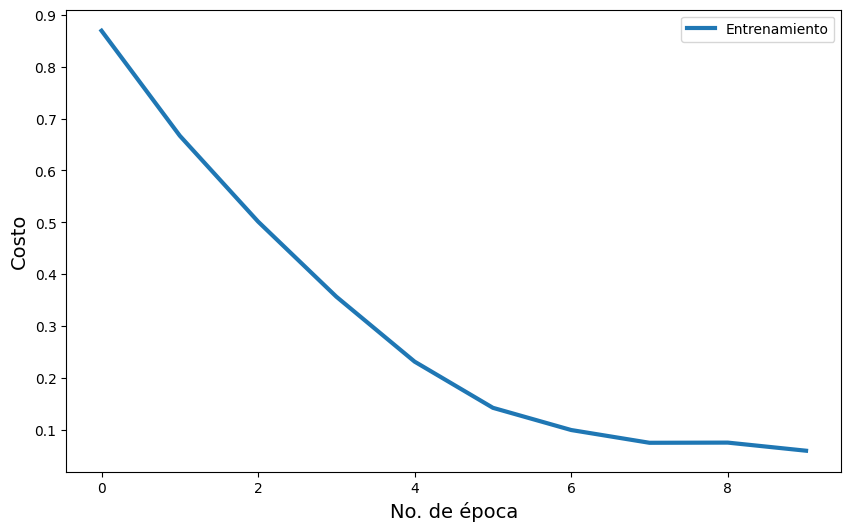

In [ ]:
# visualization of cost function(categorical crossentropy)
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], linestyle='-', linewidth=3.0, label='Training')
#plt.plot(history.history['val_loss'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.legend()

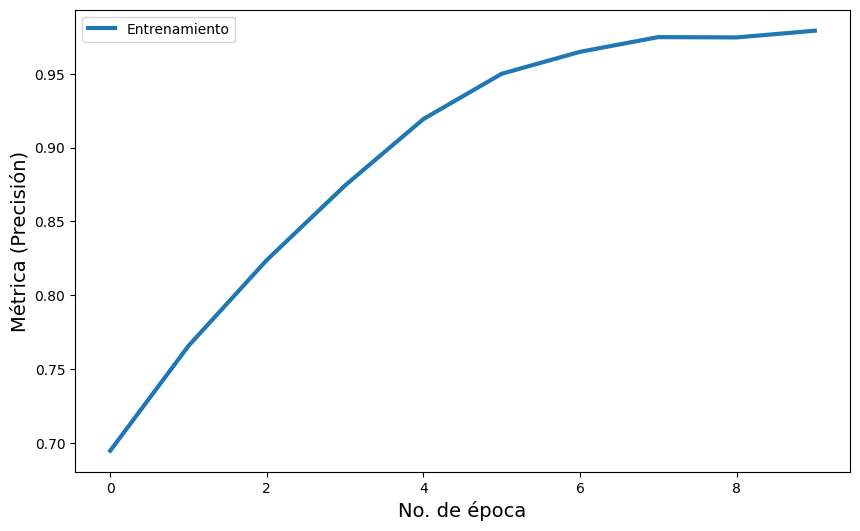

In [ ]:
# visualization of accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linestyle='-', linewidth=3.0, label='Training')
#plt.plot(history.history['val_accuracy'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Metric (Accuracy)', fontsize=14)
plt.legend()

In [ ]:
# model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print('Pérdida (validación):', val_loss)
print('Exactitud (validación):', val_acc)

313/313 [==============================] - 2s 5ms/step - loss: 1.4071 - accuracy: 0.7489
Pérdida (validación): 1.407095193862915
Exactitud (validación): 0.7488999962806702


**4. Model Construction: With Dropout**

To improve the efficiency of the model, we can eliminate certain columns of the weight matrices that do not contribute to the results (Drop-out). Mathematically, experiments show that this is equivalent to multiplying Bernoulli noise in the network feature maps.

In [ ]:
# baseline model
def baseline_model(X):
  # declaramos un modelo secuencial
  model = Sequential()

  # capas convolucionales
  model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))
  model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25)) # capa de drouput
  model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25)) # capa de dropout

  # capa de aplanamiento
  model.add(Flatten())

  # capas densamente conectadas
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.4)) # capa de dropout
  model.add(Dense(250, activation='relu'))
  model.add(Dropout(0.3)) # capa de dropout

  # capa de salida (10 clases)
  model.add(Dense(10, activation='softmax'))

  # compilar modelo
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

  return model

In [ ]:
# instantiate model instance
model = baseline_model(X_train)

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 50)        1400      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 75)        33825     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 75)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 75)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 125)       84500     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 125)         0         
 g2D)                                                 

In [ ]:
# model training
history = model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
391/391 [==============================] - 16s 26ms/step - loss: 1.5593 - accuracy: 0.4287
Epoch 2/10
391/391 [==============================] - 10s 25ms/step - loss: 1.0917 - accuracy: 0.6115
Epoch 3/10
391/391 [==============================] - 9s 23ms/step - loss: 0.9094 - accuracy: 0.6807
Epoch 4/10
391/391 [==============================] - 9s 23ms/step - loss: 0.7964 - accuracy: 0.7216
Epoch 5/10
391/391 [==============================] - 9s 23ms/step - loss: 0.7193 - accuracy: 0.7479
Epoch 6/10
391/391 [==============================] - 9s 24ms/step - loss: 0.6482 - accuracy: 0.7729
Epoch 7/10
391/391 [==============================] - 10s 25ms/step - loss: 0.5941 - accuracy: 0.7929
Epoch 8/10
391/391 [==============================] - 9s 24ms/step - loss: 0.5429 - accuracy: 0.8078
Epoch 9/10
391/391 [==============================] - 9s 24ms/step - loss: 0.5000 - accuracy: 0.8237
Epoch 10/10
391/391 [==============================] - 9s 23ms/step - loss: 0.4591 - acc

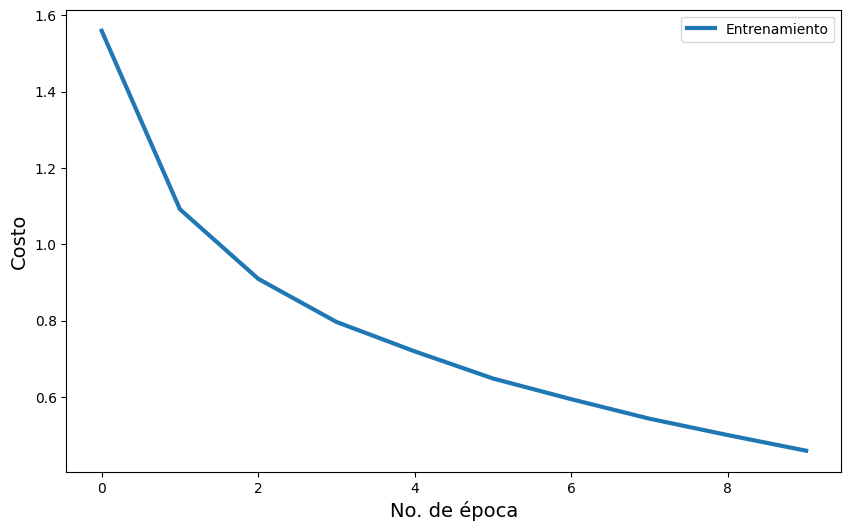

In [ ]:
# visualization of cost function (categorical crossentropy)
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], linestyle='-', linewidth=3.0, label='Training')
#plt.plot(history.history['val_loss'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.legend()

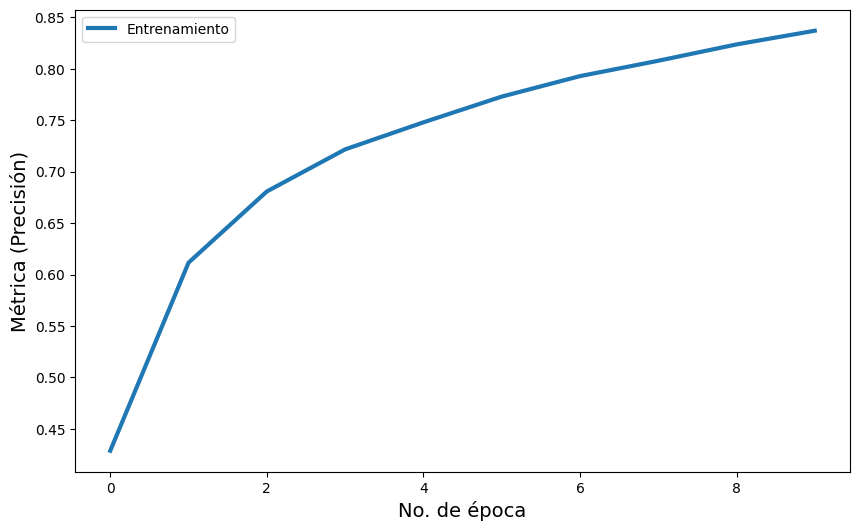

In [ ]:
# visualization of accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linestyle='-', linewidth=3.0, label='Training')
#plt.plot(history.history['val_accuracy'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Metric (Accuracy)', fontsize=14)
plt.legend()

In [ ]:
# model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print('Pérdida (validación):', val_loss)
print('Exactitud (validación):', val_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.6870 - accuracy: 0.7734
Pérdida (validación): 0.6870220899581909
Exactitud (validación): 0.7734000086784363


### Imagenette

Imagenette is a simplified version of the popular ImageNet dataset, which originally contains 14 million images of size 224x224 pixels for 20,000 object classes. Since this is not practical for illustrative examples, Jeremy Howard made a simplified version with only 10 classes and 1000 images for each.

**1. Dataset exploration**

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xf imagenette2.tgz

--2024-04-06 21:29:05--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.199.56, 52.216.24.118, 52.217.229.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.199.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  55.1MB/s    in 27s     

2024-04-06 21:29:32 (55.6 MB/s) - ‘imagenette2.tgz’ saved [1557161267/1557161267]



We define the names of the classes of the sample dataset.

In [ ]:
imagenette_map = {
    "n01440764" : "tench",
    "n02102040" : "springer",
    "n02979186" : "casette_player",
    "n03000684" : "chain_saw",
    "n03028079" : "church",
    "n03394916" : "French_horn",
    "n03417042" : "garbage_truck",
    "n03425413" : "gas_pump",
    "n03445777" : "golf_ball",
    "n03888257" : "parachute"
}

Utilizamos la función de ImageGenerator para extraer las imágenes en un directorio y aplicar transformaciones adicionales para aumento de datos (data augmentation), convirtiéndolos en un generador fácilmente extraíble para modelos de Tensorflow.

In [ ]:
# create generator
imagegen = ImageDataGenerator()

# load training data
train = imagegen.flow_from_directory("imagenette2/train/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))

# load validation data
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


The images already come pre-processed and ready to be entered into the model. We can view some for convenience.

**2. Construction of the base model**

In [ ]:
# baseline model
def baseline_model(X):
  # iniciar modelo secuencial
  model = Sequential()
  model.add(InputLayer(input_shape=(224, 224, 3)))

  # 1er bloque convolucional
  model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
  # 2do bloque convolucional
  model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
  model.add(BatchNormalization())
  # 3er bloque convolucional
  model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
  model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
  model.add(BatchNormalization())
  # bloque DNN
  model.add(Flatten())
  model.add(Dense(units=100, activation='relu'))
  model.add(Dense(units=100, activation='relu'))
  model.add(Dropout(0.25))

  # capa de salida (10 clases)
  model.add(Dense(units=10, activation='softmax'))

  # compile model
  model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

  return model

In [ ]:
# instantiat model instance
model = baseline_model(X_train)

# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 25)      1900      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 25)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 50)        31300     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 50)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 28, 28, 50)        200       
 Normalization)                                                  
                                                      

In [ ]:
# model training
history = model.fit_generator(train, epochs=30, validation_data=val)

<ipython-input-41-92f8a22cbe4c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train, epochs=30, validation_data=val)


Epoch 1/30
74/74 [==============================] - 105s 1s/step - loss: 2.5840 - accuracy: 0.1283 - val_loss: 2.5490 - val_accuracy: 0.1057
Epoch 2/30
74/74 [==============================] - 76s 1s/step - loss: 2.2655 - accuracy: 0.1795 - val_loss: 2.2444 - val_accuracy: 0.1908
Epoch 3/30
74/74 [==============================] - 67s 914ms/step - loss: 2.0904 - accuracy: 0.2752 - val_loss: 4.8852 - val_accuracy: 0.1488
Epoch 4/30
74/74 [==============================] - 77s 1s/step - loss: 1.8980 - accuracy: 0.3502 - val_loss: 1.9182 - val_accuracy: 0.3422
Epoch 5/30
74/74 [==============================] - 81s 1s/step - loss: 1.5930 - accuracy: 0.4669 - val_loss: 2.4433 - val_accuracy: 0.1845
Epoch 6/30
74/74 [==============================] - 67s 893ms/step - loss: 1.4093 - accuracy: 0.5255 - val_loss: 2.1274 - val_accuracy: 0.3294
Epoch 7/30
74/74 [==============================] - 67s 898ms/step - loss: 1.1951 - accuracy: 0.6136 - val_loss: 1.9369 - val_accuracy: 0.3725
Epoch 8/30

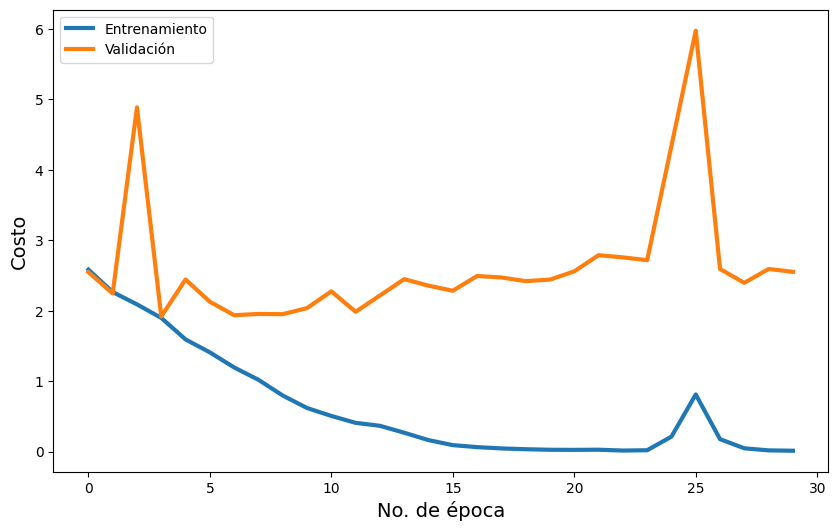

In [ ]:
# visualization of cost function (categorical crossentropy)
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], linestyle='-', linewidth=3.0, label='Training')
plt.plot(history.history['val_loss'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.legend()

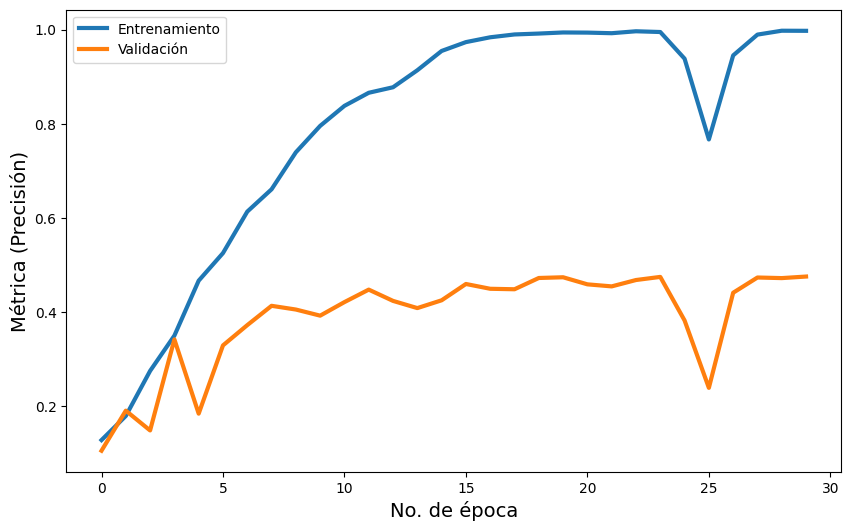

In [ ]:
# visualization of accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], linestyle='-', linewidth=3.0, label='Training')
plt.plot(history.history['val_accuracy'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch Number', fontsize=14)
plt.ylabel('Metric (Accuracy)', fontsize=14)
plt.legend()

**Improve accuracy with VGG16**

Although we have built a neural network with 3 convolutional layers, we have not yet achieved a desirable precision. Instead of training a network from scratch, however, we can use a model pre-trained on a larger number of images, and tune it to work on our dataset.

The process of starting from a base model and extracting additional information, or training only certain layers (fine-tuning) is known as Transfer Learning.

In [ ]:
from keras.applications import VGG16

# we remove the last layer because we customize the output
# we load the weights of the model trained with ImageNet
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

**Method 1**: We can extract useful features from images that VGG16 has already been trained to recognize.

In [ ]:
# extract train and val features
vgg_features_train = pretrained_model.predict(train)
vgg_features_val = pretrained_model.predict(val)

31/31 [==============================] - 31s 1s/step


We apply one-hot encoding to add them to the training and validation sets.

In [ ]:
train_target = to_categorical(train.labels)
val_target = to_categorical(val.labels)

One way to do transfer learning is to introduce the features extracted with the help of the base model into a simpler model. In this case, we use a simple densely connected (DNN) model.

In [ ]:
# baseline model
def dnn_model(X):

  # iniciar modelo secuencial
  model = Sequential()
  model.add(Flatten(input_shape=(7,7,512)))
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(10, activation='softmax'))

  # compilar el modelo
  model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

  return model

In [ ]:
# instanciate a new model
model2 = dnn_model(X_train)
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 100)               2508900   
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 2510310 (9.58 MB)
Trainable params: 2510110 (9.58 MB)
Non-trainable params: 200 (800.00 Byte)
____________

In [ ]:
# model training
history2 = model2.fit(vgg_features_train, train_target, epochs=30, batch_size=128, validation_data=(vgg_features_val, val_target))

Epoch 1/30
74/74 [==============================] - 1s 14ms/step - loss: 0.0526 - accuracy: 0.9946 - val_loss: 0.1691 - val_accuracy: 0.9478
Epoch 2/30
74/74 [==============================] - 1s 15ms/step - loss: 0.0334 - accuracy: 0.9973 - val_loss: 0.1644 - val_accuracy: 0.9475
Epoch 3/30
74/74 [==============================] - 1s 13ms/step - loss: 0.0217 - accuracy: 0.9988 - val_loss: 0.1685 - val_accuracy: 0.9468
Epoch 4/30
74/74 [==============================] - 1s 16ms/step - loss: 0.0155 - accuracy: 0.9995 - val_loss: 0.1653 - val_accuracy: 0.9460
Epoch 5/30
74/74 [==============================] - 2s 28ms/step - loss: 0.0138 - accuracy: 0.9987 - val_loss: 0.1678 - val_accuracy: 0.9457
Epoch 6/30
74/74 [==============================] - 2s 27ms/step - loss: 0.0108 - accuracy: 0.9989 - val_loss: 0.1731 - val_accuracy: 0.9452
Epoch 7/30
74/74 [==============================] - 1s 14ms/step - loss: 0.0095 - accuracy: 0.9994 - val_loss: 0.1765 - val_accuracy: 0.9457
Epoch 8/30
74

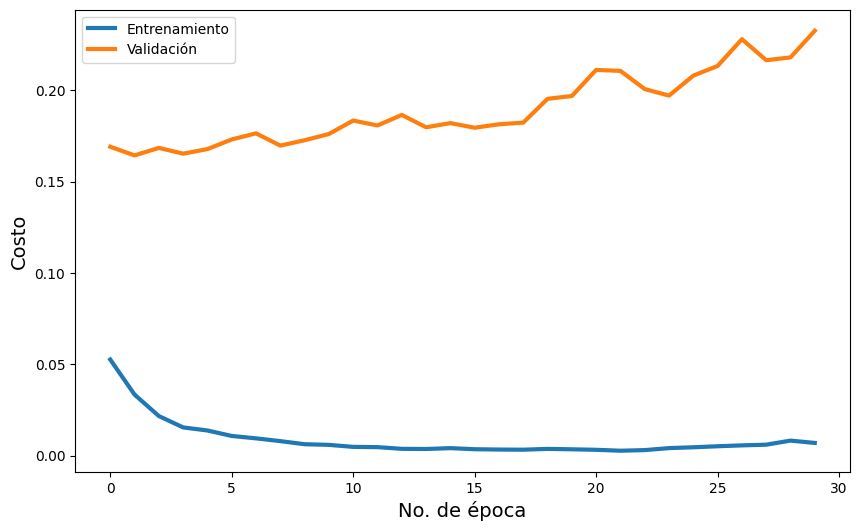

In [ ]:
# visualization of cost function (categorical crossentropy)
fig = plt.figure(figsize=(10,6))
plt.plot(history2.history['loss'], linestyle='-', linewidth=3.0, label='Training')
plt.plot(history2.history['val_loss'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.legend()

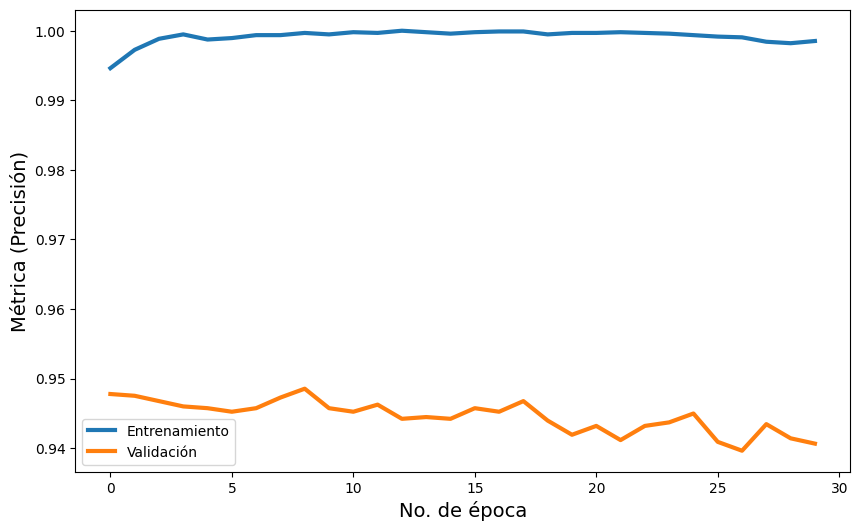

In [ ]:
# visualization of accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history2.history['accuracy'], linestyle='-', linewidth=3.0, label='Training')
plt.plot(history2.history['val_accuracy'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Metric (Accuracy)', fontsize=14)
plt.legend()

**Method 2**: Another way to perform transfer learning is to take the entire model (minus the last layer), and add additional layers that will be the only ones trained. Untrainable layers are known as frozen layers.

In [ ]:
# finetuned model
def finetuned_model():

  IMAGE_SIZE = [224, 244]

  # cargar modelo pre-entrenado
  vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

  # congelar las capas del modelo
  for layer in vgg.layers:
    layer.trainable = False

  # agregar capas de clasificación
  x = Flatten()(vgg.output)
  prediction = Dense(10, activation='softmax')(x)
  model = Model(inputs=vgg.input, outputs=prediction)

  # compilar el modelo
  model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

  return model

In [ ]:
# instantiate a new model
model3 = finetuned_model()
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 61, 128)       0     

In [ ]:
# model training
history3 = model3.fit_generator(train, epochs=30, validation_data=val)

<ipython-input-13-9b622cdf0ff7>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(train, epochs=30, validation_data=val)


Epoch 1/30
74/74 [==============================] - 78s 1s/step - loss: 72.1694 - accuracy: 0.5166 - val_loss: 36.1562 - val_accuracy: 0.7213
Epoch 2/30
74/74 [==============================] - 75s 1s/step - loss: 6.5091 - accuracy: 0.9158 - val_loss: 4.0703 - val_accuracy: 0.9246
Epoch 3/30
74/74 [==============================] - 74s 1s/step - loss: 0.7060 - accuracy: 0.9779 - val_loss: 3.3223 - val_accuracy: 0.9274
Epoch 4/30
74/74 [==============================] - 74s 1s/step - loss: 0.1386 - accuracy: 0.9906 - val_loss: 3.0071 - val_accuracy: 0.9332
Epoch 5/30
74/74 [==============================] - 75s 1s/step - loss: 0.0394 - accuracy: 0.9956 - val_loss: 2.9219 - val_accuracy: 0.9325
Epoch 6/30
74/74 [==============================] - 74s 1s/step - loss: 8.3672e-04 - accuracy: 0.9997 - val_loss: 2.9371 - val_accuracy: 0.9307
Epoch 7/30
74/74 [==============================] - 74s 996ms/step - loss: 6.6235e-04 - accuracy: 0.9999 - val_loss: 2.9125 - val_accuracy: 0.9320
Epoch 8

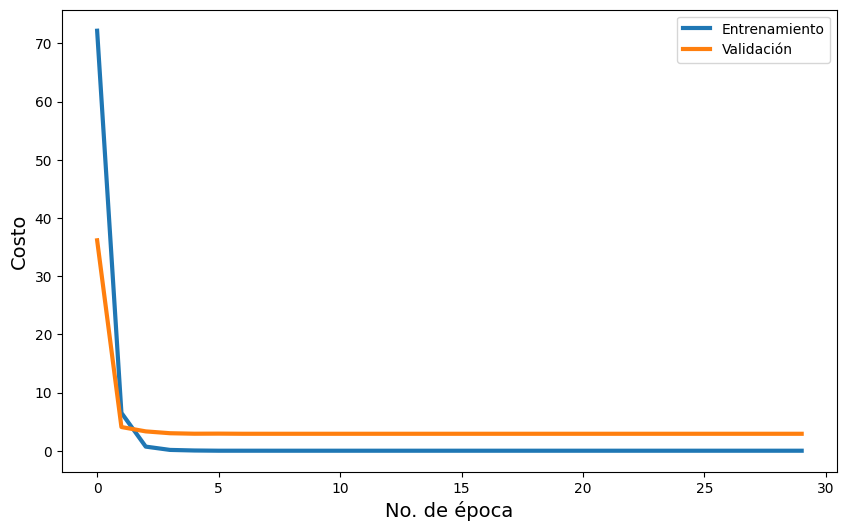

In [ ]:
# visualization of cost function (categorical crossentropy)
fig = plt.figure(figsize=(10,6))
plt.plot(history3.history['loss'], linestyle='-', linewidth=3.0, label='Training')
plt.plot(history3.history['val_loss'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.legend()

In [ ]:
# visualization of accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history2.history['accuracy'], linestyle='-', linewidth=3.0, label='Training')
plt.plot(history.history['val_accuracy'], linestyle='-', linewidth=3.0, label='Validation')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Metric (Accuracy)', fontsize=14)
plt.legend()